# Module 3: Machine Learning

## Sprint 4: Machine Learning capstone project

## Kaggle competition with a complex dataset

## Background

---

Participating in Kaggle competitions is an efficient way to learn some aspects of Machine Learning. You can read solutions made public by the others, participate in the discussions to talk about solution ideas and test them by submitting them for evaluation.

The metric used for evaluation can vary from competition to competition, but the idea remains the same - build a model that is as accurate as possible on the testing set. In industry, there are other factors to consider when building machine learning models - inference time, solution complexity, maintainability and so on. However, even though you only learn a subset of the required skills while participating in Kaggle competitions, it is quite a fun way to learn by doing it, so let's participate in one of the competitions again! This time, a competition having a really complex dataset.

## The competition

Pick and participate in one of the following Kaggle competitions, where they all have complex datasets, which creates a lot of space for creative feature engineering and model building:

- https://www.kaggle.com/c/petfinder-adoption-prediction/overview
- https://www.kaggle.com/c/avito-demand-prediction/overview
- https://www.kaggle.com/c/home-credit-default-risk/overview

For help, you can look at some of the notebooks by other competitors. However, try to write code by yourself, as even though you will always be able to consult external resources while working as a professional, the main thing right now to is learn, not to get a good score in the leaderboard.

---

## Requirements

- Data exploration
- Feature engineering
- At least several different models built and compared to each other on the validation set and on the public and private leaderboards
- Clean code
- At least median private leaderboard score

## Evaluation criteria

- Private leaderboard score
- How simple is the model
- How fast is the model prediction
- Code quality

# Kaggle competition "Home Credit Default Risk"

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import optuna
import eli5
import lightgbm as lgbm
from lightgbm import LGBMModel, LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from scipy.stats import uniform
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import time
import warnings

from functions import (
    DataFrameImputer,
    get_feature_importance,
    get_mean_scores,
    percent_missing,
    change_to_other,
    find_relation,
    find_relation_in_groups,
    clean_object_features
)

warnings.filterwarnings("ignore")

RANDOM = 42

In [18]:
application_train = pd.read_csv("application_train.csv")
application_test = pd.read_csv("application_test.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv")
credit_card_balance = pd.read_csv("credit_card_balance.csv")
previous_application = pd.read_csv("previous_application.csv")
installments_payments = pd.read_csv("installments_payments.csv")
HomeCredit_columns_description = pd.read_csv("HomeCredit_columns_description.csv")

## BASIC DATA ANALYSIS

In [19]:
pd.set_option('display.max_columns', 500)
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Main file contains information about applied person's gender, some possessions, family, occupancy, residence and application information such as weekday, time, provided documents, etc.

In [250]:
application_train.shape

(307511, 122)

In [6]:
application_test.shape

(48744, 121)

In [7]:
application_train["TARGET"].value_counts(1)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

TARGET: binary classification, 1 - client with payment difficulties, 0 - all other cases. Usually banks rather do not provide loan for person who will return than provide to somebody who won't. So the aim is to identify if client might not return the loan and precision in 1 group suppose to be the most important metric. 

GOAL: submissions are evaluated on area under the ROC curve between the predicted probability and the observed target. My goal is to have a median accuracy on private leadearboard, which is 0.78592, or better. Highest score on private board was 0.80570, so the goal seems to be challenging. 

In [83]:
app_train_gender = find_relation(application_train, "CODE_GENDER", "TARGET")

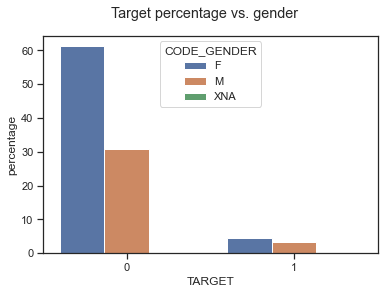

In [255]:
sns.barplot(data=app_train_gender, x="TARGET", y="percentage", hue="CODE_GENDER")
plt.suptitle("Target percentage vs. gender")

Females apply for the loan almost twice as much as males, but they also have a better ratio of returning the loan back. To speak in numbers, payment difficulties will have 7% of women and 10.1% of men. 

Owning a car or a realty did not effect the percentage for more than 0.01%, but having children did: 

In [239]:
app_train_children = find_relation(application_train, "CNT_CHILDREN", "TARGET")
app_train_children = app_train_children.drop("percentage", axis=1)

In [240]:
new_row_0 = 0
new_row_1 = 0
for index, row in app_train_children.iterrows():
    if row["CNT_CHILDREN"] > 2 and row["TARGET"] == 0:
        new_row_0 = new_row_0 + row["total"]
        app_train_children.drop(index, inplace=True)
    if row["CNT_CHILDREN"] > 2 and row["TARGET"] == 1:
        new_row_1 = new_row_1 + row["total"]
        app_train_children.drop(index, inplace=True)

more_than_2_0 = {"CNT_CHILDREN": "3 and more", "TARGET": 0, "total": new_row_0}
more_than_2_1 = {"CNT_CHILDREN": "3 and more", "TARGET": 1, "total": new_row_1}
app_train_children = app_train_children.append(more_than_2_0, ignore_index=True)
app_train_children = app_train_children.append(more_than_2_1, ignore_index=True)

In [245]:
app_train_children = find_relation_in_groups(
    app_train_children, "CNT_CHILDREN", "TARGET"
)

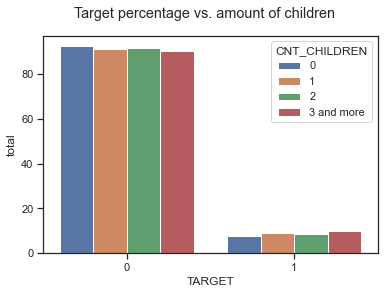

In [256]:
sns.barplot(data=app_train_children, x="TARGET", y="total", hue="CNT_CHILDREN")
plt.suptitle("Target percentage vs. amount of children")

70% of applicants did not have children but the ones who had found it slightly more difficult to return, and the more children, the higher percent. It grows from 7.7% (no children) to 10.04% (3 and more children). 

Another observation is what income type has the applicant and how it impacts if client will return the loan or not. The smaller groups such as businessman and student have 100% rate while Maternity leave and unemployed have the lowest: 60 and 63% respectively. Unfortunately all these groups are too small (less than 1% each) for model to generalize results and main focus should remain on working, commercial associate and pensioner groups. All of the later have a rates accordingly 90%, 92% and 94% (see plot below). 

In [228]:
app_train_income = find_relation_in_groups(
    application_train, "NAME_INCOME_TYPE", "TARGET"
)

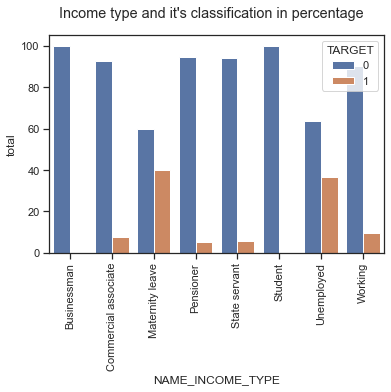

In [257]:
sns.barplot(data=app_train_income, x="NAME_INCOME_TYPE", y="total", hue="TARGET")
plt.xticks(rotation=90)
plt.suptitle("Income type and it's classification in percentage")

The highest amount of people (a bit more tham 70%) who apply for the loan have Secondary / secondary special education. Second biggest group (around 24%) has higher education. Other groups are very small, but still let's see the behaviour patterns according to it:

In [231]:
app_train_education = find_relation_in_groups(
    application_train, "NAME_EDUCATION_TYPE", "TARGET"
)

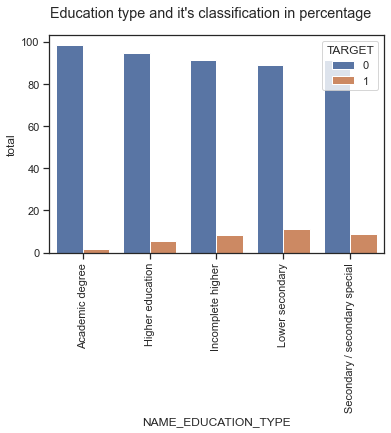

In [254]:
sns.barplot(data=app_train_education, x="NAME_EDUCATION_TYPE", y="total", hue="TARGET")
plt.xticks(rotation=90)
plt.suptitle("Education type and it's classification in percentage")

From the plot above we see that he higher education, the bigger percent of people who return the loan without issues.  
What about clients age and employment days: 

In [199]:
app_train_days = application_train[["TARGET", "DAYS_BIRTH", "DAYS_EMPLOYED"]]
app_train_days = app_train_days[app_train_days.DAYS_EMPLOYED != 365243]

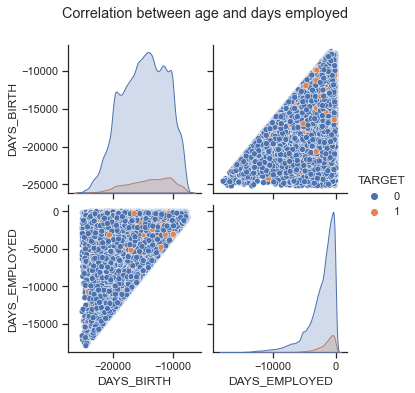

In [258]:
sns.pairplot(app_train_days, hue="TARGET")
plt.suptitle("Correlation between age and days employed");

It seems that the shorter time period the person is employed, the higher chances that he will apply for the loan and possibly won't be able to get it back (it is possible that such persons have a tendency to be unemployed too). Another natural correlation is that the younger the person is, the shorter time he is employed, but it seems that these people are also having a bigger tendency to have difficulties in paying back. 

Let's see if modelling also see similar results in feature importance.

To begin with, I will impute missing values with mean or most freaquent values and make few baseline models.   
For the baseline model I will try several models:         
* LogisticRegression,
* LightGBM,
* RandomForestClassifier,
* GradientBoostingClassifier,
* XGBClassifier,
* CatBoostClassifier.   

My decision to choose these models are based on my own experience in previous projects and experience of my peers and kaggle competitors for this project. I will reduce number of models to 3-4 after reviewing first results.

## BASELINE MODEL

I will have several datasets (only from application_train file) for baseline model in order to make better choice: 
1. application_train data, simply imputed;
2. features from application_train selected with l1 from Logistic regression model;
3. repeated most important features from several models;
4. all most important features from several models. 

In [24]:
application_train_imputed = DataFrameImputer().fit_transform(application_train)

In [29]:
application_train_imputed_enc = pd.get_dummies(
    application_train_imputed, drop_first=True
)

train_sample = application_train_imputed_enc.sample(
    frac=0.01, replace=True, random_state=42
)
features_list = list(train_sample.columns[2:])

X_app_all = train_sample[train_sample.columns[2:]].values
y = train_sample["TARGET"].to_numpy()

In [32]:
main_features = list(
    set(top_features_lr) & set(top_lgb_features) & set(top_xgb_features)
)
main_features.sort()

all_features = set(top_features_lr + top_lgb_features + top_xgb_features)

In [37]:
X_main_features = train_sample[main_features].values
X_all_selected = train_sample[all_features].values

In [77]:
datasets = [X_app_all, X_lr_top, X_main_features, X_all_selected]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_app_all, y, test_size=0.2, random_state=RANDOM
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic regression

#### Select main features

In [9]:
eli5.explain_weights(lr, top=10, feature_names=features_list)

Explanation(estimator="LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='liblinear')", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='CODE_GENDER_M', weight=0.27824365138298385, std=None, value=None), FeatureWeight(feature='NAME_INCOME_TYPE_Working', weight=0.1335045680107794, std=None, value=None), FeatureWeight(feature='OBS_60_CNT_SOCIAL_CIRCLE', weight=0.12459110077426466, std=None, value=None), FeatureWeight(feature='ORGANIZATION_TYPE_Agriculture', weight=0.120874859492022, std=None, value=None), FeatureWeight(feature='ORGANIZATION_TYPE_Self-employed', weight=0.11118717232112532, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-2.7325733191789774, std=None, value=None), FeatureWeight(feature='EXT_SOURCE_2', weight=-0.40019385015244696, std=None, value=None), FeatureWeight(feature='EXT_SOURCE_3', weight=-0.38386475449063545, std=None, value=None), FeatureWeight(feature='OCCUPATION_TYPE_Core staff', weight=-0.14758758839834432, std=None, value=None), FeatureWeight(feature='AMT_REQ_CREDIT_BUREAU_WEEK', weight=-0.11685983382132374, std=None, value=None)], pos_remaining=28, neg_remaining=27), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [10]:
top_features_lr = [
    i[:]
    for i in eli5.formatters.as_dataframe.explain_weights_df(
        lr, feature_names=features_list
    ).feature[:]
    if "BIAS" not in i
]

X_lr_top = train_sample[top_features_lr].values

#### Results

In [83]:
lr = LogisticRegression(random_state=RANDOM)
get_mean_scores(lr, datasets, y)

('CV_all mean score all: 0.634',
 'CV_all mean score top lr: 0.73',
 'CV_all mean score main features: 0.75',
 'CV_all mean score all selected features: 0.634')

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X_main_features, y, test_size=0.2, random_state=RANDOM
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [102]:
lr = LogisticRegression(max_iter=10000)

parameter_grid = {
    "class_weight": ["balanced", None],
    "penalty": ["l2", "l1"],
    "C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    "solver": ["newton-cg", "sag", "lbfgs", "liblinear"],
}

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train, y_train)
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

Best score: 0.7639434885850376
Best parameters: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


In [108]:
lr = LogisticRegression(
    class_weight="balanced",
    random_state=RANDOM,
    penalty="l2",
    C=10.0,
    solver="liblinear",
)
lr.fit(X_train, y_train)

scores_all = cross_val_score(lr, X_main_features, y, cv=5, scoring="roc_auc")

y_pred = lr.predict(X_test)

print("Train score:", lr.score(X_train, y_train))
print("CV_all mean score:", round(scores_all.mean(), 3))
print("Classification report:\n", classification_report(y_test, y_pred))

Train score: 0.7239837398373984
CV_all mean score: 0.759
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80       559
           1       0.19      0.71      0.30        56

    accuracy                           0.69       615
   macro avg       0.57      0.70      0.55       615
weighted avg       0.89      0.69      0.75       615



### LGBM Classifier

#### Select main features

In [13]:
lgb_feature_importance = lgb.feature_importances_
lgb_model_features = get_feature_importance(features_list, lgb_feature_importance)
lgb_model_features.sort_values(by=['importance'], ascending=False)

,feature,importance
20,EXT_SOURCE_2,287
21,EXT_SOURCE_3,219
2,AMT_CREDIT,171
8,DAYS_REGISTRATION,144
7,DAYS_EMPLOYED,143
...,...,...
52,NONLIVINGAPARTMENTS_MEDI,1
56,DEF_30_CNT_SOCIAL_CIRCLE,1
14,REGION_RATING_CLIENT,1
12,FLAG_PHONE,1


In [14]:
top_lgb_features = list(lgb_model_features["feature"])

#### Results

In [59]:
lgb = LGBMClassifier(random_state=RANDOM, objective="binary", verbose=-1)
get_mean_scores(lgb, datasets, y)

('CV_all mean score all: 0.719',
 'CV_all mean score top lr: 0.717',
 'CV_all mean score main features: 0.711',
 'CV_all mean score all selected features: 0.733')

In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    X_app_all, y, test_size=0.2, random_state=RANDOM
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
lgb = LGBMClassifier(random_state=RANDOM, objective="binary", verbose=-1)

parameter_grid = {
    "n_estimators": [200, 300, 500, 700],
    "feature_fraction": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 20, 30],
    "max_bin": [255, 510],
    "boosting_type": ["gbdt", "dart"],
    "num_leaves": [6, 8, 12, 16, 32, 48, 100, 130, 150, 180, 200],
    "min_data_in_leaf": [5, 10, 25, 50, 75, 100, 150],
}

grid_search = RandomizedSearchCV(lgb, parameter_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train, y_train)
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

Best score: 0.7225390120373418
Best parameters: {'num_leaves': 180, 'n_estimators': 500, 'min_data_in_leaf': 10, 'max_depth': 3, 'max_bin': 510, 'feature_fraction': 0.7, 'boosting_type': 'dart'}

In [ ]:
lgb = LGBMClassifier(
    random_state=RANDOM,
    objective="binary",
    verbose=-1,
    num_leaves=12,
    n_estimators=500,
    min_data_in_leaf=150,
    max_depth=3,
    max_bin=510,
    feature_fraction=0.4,
    boosting_type="dart",
)

lgb.fit(X_train, y_train)

scores_all = cross_val_score(lgb, X_app_all, y, cv=3, scoring="roc_auc")
scores_lr_top = cross_val_score(lgb, X_lr_top, y, cv=3, scoring="roc_auc")
scores_main_features = cross_val_score(lgb, X_main_features, y, cv=3, scoring="roc_auc")
scores_all_selected = cross_val_score(lgb, X_all_selected, y, cv=3, scoring="roc_auc")

y_pred = lgb.predict(X_test)

print("Train score:", lgb.score(X_train, y_train))
print("CV_all mean score all:", round(scores_all.mean(), 3))
print("CV_all mean score top lr:", round(scores_lr_top.mean(), 3))
print("CV_all mean score main features:", round(scores_main_features.mean(), 3))
print("CV_all mean score all_selected features:", round(scores_all_selected.mean(), 3))
print("Classification report:\n", classification_report(y_test, y_pred))

Train score: 0.9235772357723577
CV_all mean score all: 0.752
CV_all mean score top lr: 0.732
CV_all mean score main features: 0.733
CV_all mean score all_selected features: 0.746
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       559
           1       0.67      0.04      0.07        56

    accuracy                           0.91       615
   macro avg       0.79      0.52      0.51       615
weighted avg       0.89      0.91      0.87       615

### Random Forest Classifier

#### Results

In [48]:
rfc = RandomForestClassifier(random_state=RANDOM)
get_mean_scores(rfc, datasets, y)

('CV_all mean score all: 0.681',
 'CV_all mean score top lr: 0.75',
 'CV_all mean score main features: 0.736',
 'CV_all mean score all selected features: 0.707')

In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    X_lr_top, y, test_size=0.2, random_state=RANDOM
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [118]:
rfc = RandomForestClassifier()

parameter_grid = {
    "class_weight": [None, "balanced"],
    "n_estimators": [200, 300, 500, 700],
    "min_samples_split": [2, 3, 4, 5, 6],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": [2, 3, 4, 5, 6, 7, 8],
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 20, 30],
}

grid_search = RandomizedSearchCV(rfc, parameter_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train, y_train)
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

Best score: 0.759087551236719
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 8, 'class_weight': None}


In [119]:
rfc = RandomForestClassifier(
    class_weight=None,
    max_depth=8,
    max_features=3,
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=5,
)
rfc.fit(X_train, y_train)

scores_all = cross_val_score(rfc, X_app_all, y, cv=3, scoring="roc_auc")
scores_lr_top = cross_val_score(rfc, X_lr_top, y, cv=3, scoring="roc_auc")
scores_main_features = cross_val_score(rfc, X_main_features, y, cv=3, scoring="roc_auc")
scores_all_selected = cross_val_score(rfc, X_all_selected, y, cv=3, scoring="roc_auc")

y_pred = rfc.predict(X_test)

print("Train score:", rfc.score(X_train, y_train))
print("CV_all mean score all:", round(scores_all.mean(), 3))
print("CV_all mean score top lr:", round(scores_lr_top.mean(), 3))
print("CV_all mean score main features:", round(scores_main_features.mean(), 3))
print("CV_all mean score all_selected features:", round(scores_all_selected.mean(), 3))
print("Classification report:\n", classification_report(y_test, y_pred))

Train score: 0.9203252032520325
CV_all mean score all: 0.704
CV_all mean score top lr: 0.755
CV_all mean score main features: 0.75
CV_all mean score all_selected features: 0.711
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       559
           1       0.00      0.00      0.00        56

    accuracy                           0.91       615
   macro avg       0.45      0.50      0.48       615
weighted avg       0.83      0.91      0.87       615



### Gradient Boosting Classifier

#### Results

In [49]:
gbc = GradientBoostingClassifier(random_state=RANDOM)
get_mean_scores(gbc, datasets, y)

('CV_all mean score all: 0.74',
 'CV_all mean score top lr: 0.746',
 'CV_all mean score main features: 0.732',
 'CV_all mean score all selected features: 0.744')

In [120]:
gbc = GradientBoostingClassifier()

parameter_grid = {
    "learning_rate": [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "ccp_alpha": uniform(loc=0, scale=0.1),
    "n_estimators": sp_randInt(100, 1000),
    "max_depth": sp_randInt(2, 10),
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8],
    "min_samples_leaf": [2, 3, 4, 5, 6, 7, 8],
}

grid_search = RandomizedSearchCV(gbc, parameter_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train, y_train)
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

Best score: 0.6506275627751557
Best parameters: {'ccp_alpha': 0.0025954465866409927, 'learning_rate': 0.001, 'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 7, 'n_estimators': 452, 'subsample': 0.5}


In [121]:
gbc = GradientBoostingClassifier(
    learning_rate=0.001,
    max_depth=2,
    n_estimators=452,
    subsample=0.5,
    ccp_alpha=0.0025954465866409927,
    min_samples_leaf=6,
    min_samples_split=7,
)
gbc.fit(X_train, y_train)

scores_all = cross_val_score(gbc, X_app_all, y, cv=3, scoring="roc_auc")
scores_lr_top = cross_val_score(gbc, X_lr_top, y, cv=3, scoring="roc_auc")
scores_main_features = cross_val_score(gbc, X_main_features, y, cv=3, scoring="roc_auc")
scores_all_selected = cross_val_score(gbc, X_all_selected, y, cv=3, scoring="roc_auc")

y_pred = gbc.predict(X_test)

print("Train score:", gbc.score(X_train, y_train))
print("CV_all mean score all:", round(scores_all.mean(), 3))
print("CV_all mean score top lr:", round(scores_lr_top.mean(), 3))
print("CV_all mean score main features:", round(scores_main_features.mean(), 3))
print("CV_all mean score all_selected features:", round(scores_all_selected.mean(), 3))
print("Classification report:\n", classification_report(y_test, y_pred))

Train score: 0.9203252032520325
CV_all mean score all: 0.694
CV_all mean score top lr: 0.697
CV_all mean score main features: 0.688
CV_all mean score all_selected features: 0.69
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       559
           1       0.00      0.00      0.00        56

    accuracy                           0.91       615
   macro avg       0.45      0.50      0.48       615
weighted avg       0.83      0.91      0.87       615



### XGB Classifier

#### Select main features

In [30]:
xgb_feature_importance = xgb.feature_importances_
xgb_model_features = get_feature_importance(features_list, xgb_feature_importance)
xgb_model_features.sort_values(by=["importance"], ascending=False)

,feature,importance
55,FLAG_OWN_CAR_Y,0.024956
54,CODE_GENDER_M,0.023586
18,EXT_SOURCE_2,0.022477
58,NAME_INCOME_TYPE_Working,0.018849
3,AMT_ANNUITY,0.018345
...,...,...
60,NAME_FAMILY_STATUS_Married,0.005758
27,LIVINGAPARTMENTS_AVG,0.005675
51,AMT_REQ_CREDIT_BUREAU_MON,0.005659
79,"WALLSMATERIAL_MODE_Stone, brick",0.005183


In [31]:
top_xgb_features = list(xgb_model_features["feature"])

#### Results

In [68]:
xgb = XGBClassifier(random_state=RANDOM)
get_mean_scores(xgb, datasets, y)

('CV_all mean score all: 0.711',
 'CV_all mean score top lr: 0.706',
 'CV_all mean score main features: 0.679',
 'CV_all mean score all selected features: 0.714')

In [122]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all_selected, y, test_size=0.2, random_state=RANDOM
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [123]:
xgb = XGBClassifier(verbosity=0, nthread=4, objective="binary:logistic")

parameter_grid = {
    "max_depth": list(range(2, 6)),
    #     "weights": [1, 10, 25, 50, 75, 99, 100, 1000],
    "min_child_weight": list(range(1, 20)),
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
    "gamma": [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    "colsample_bytree": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "reg_lambda": [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 100],
    "learning_rate": [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.13, 0.16, 0.19,],
    "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000],
}

grid_search = RandomizedSearchCV(xgb, parameter_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train, y_train)
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

Best score: 0.7261318199372762
Best parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.45, 'colsample_bytree': 0.5}


In [145]:
xgb = XGBClassifier(
#     scale_pos_weight=100,
    verbosity=0,
    nthread=4,
    objective="binary:logistic",
    colsample_bytree=1,
    gamma=0.2,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=1,
    n_estimators=200,
    reg_alpha=0.1,
    reg_lambda=3.5,
    subsample=0.9,
)

xgb.fit(X_train, y_train)

scores_all = cross_val_score(xgb, X_app_all, y, cv=3, scoring="roc_auc")
scores_lr_top = cross_val_score(xgb, X_lr_top, y, cv=3, scoring="roc_auc")
scores_main_features = cross_val_score(xgb, X_main_features, y, cv=3, scoring="roc_auc")
scores_all_selected = cross_val_score(xgb, X_all_selected, y, cv=3, scoring="roc_auc")

y_pred = xgb.predict(X_test)

print("Train score:", xgb.score(X_train, y_train))
print("CV_all mean score all:", round(scores_all.mean(), 3))
print("CV_all mean score top lr:", round(scores_lr_top.mean(), 3))
print("CV_all mean score main features:", round(scores_main_features.mean(), 3))
print("CV_all mean score all_selected features:", round(scores_all_selected.mean(), 3))
print("Classification report:\n", classification_report(y_test, y_pred))

Train score: 0.925609756097561
CV_all mean score all: 0.755
CV_all mean score top lr: 0.748
CV_all mean score main features: 0.747
CV_all mean score all_selected features: 0.756
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       559
           1       1.00      0.05      0.10        56

    accuracy                           0.91       615
   macro avg       0.96      0.53      0.53       615
weighted avg       0.92      0.91      0.88       615



### CatBoost Classifier

#### Results

In [73]:
cbc = CatBoostClassifier(random_state=RANDOM)
get_mean_scores(cbc, datasets, y)

('CV_all mean score all: 0.739',
 'CV_all mean score top lr: 0.751',
 'CV_all mean score main features: 0.734',
 'CV_all mean score all selected features: 0.748')

In [127]:
X_train, X_test, y_train, y_test = train_test_split(
    X_lr_top, y, test_size=0.2, random_state=RANDOM
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [134]:
cbc = CatBoostClassifier(random_state=RANDOM)

weights = np.linspace(0.0, 0.99, 200)

param_dist = {
    "learning_rate": np.linspace(0, 0.2, 5),
    "max_depth": sp_randInt(3, 10),
    "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000],
    "reg_lambda": [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
    #     "class_weights": [{0:x, 1:1.0-x} for x in weights]
}

rscv = RandomizedSearchCV(cbc, param_dist, scoring="roc_auc", cv=5)
rscv.fit(X_train,y_train)
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'reg_lambda': 4, 'subsample': 0.8}
0.7374115019202343

In [147]:
cbc = CatBoostClassifier(
    random_state=RANDOM,
    verbose=0,
    #     class_weights= {0: 0.4278391959798995, 1: 0.5721608040201005},
    #     max_depth=4,
    #     learning_rate=0.05,
    #     n_estimators=400,
    #     reg_lambda=2.5,
    #     subsample=0.8,
)

cbc.fit(X_train, y_train)

scores_lr_top = cross_val_score(cbc, X_lr_top, y, cv=3, scoring="roc_auc")
scores_all_selected = cross_val_score(cbc, X_all_selected, y, cv=3, scoring="roc_auc")

y_pred = cbc.predict(X_test)

print("Train score:", cbc.score(X_train, y_train))
print("CV_all mean score lr top:", round(scores_lr_top.mean(), 3))
print("CV_all mean score all_selected features:", round(scores_all_selected.mean(), 3))
print("Classification report:\n", classification_report(y_test, y_pred))

Train score: 0.9577235772357724
CV_all mean score lr top: 0.751
CV_all mean score all_selected features: 0.748
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       559
           1       0.75      0.05      0.10        56

    accuracy                           0.91       615
   macro avg       0.83      0.53      0.53       615
weighted avg       0.90      0.91      0.88       615



### Baseline modelling results and conclusions

In [153]:
basic_model_results = {
    "model": [
        "LogisticRegression",
        "LightGBM",
        "RandomForestClassifier",
        "GradientBoostingClassifier",
        "XGBClassifier",
        "CatBoostClassifier",
    ],
    "all features score": [0.634, 0.719, 0.681, 0.740, 0.711, 0.739],
    "top lr features": [0.730, 0.717, 0.750, 0.746, 0.706, 0.751],
    "main features": [0.750, 0.711, 0.736, 0.732, 0.679, 0.734],
    "all selected features": [0.634, 0.733, 0.707, 0.744, 0.714, 0.748],
    "best dataset with tuned parameters": [0.759, 0.752, 0.755, 0.697, 0.756, 0.751],
    "train score": [0.724, 0.924, 0.920, 0.920, 0.925, 0.958],
    "1 class precision": [0.19, 0.67, 0.00, 0.00, 1.00, 0.75],
    "accuracy": [0.69, 0.91, 0.91, 0.91, 0.91, 0.91],
}

In [155]:
basic_modelling = pd.DataFrame.from_dict(basic_model_results)
basic_modelling["overall score"] = (
    basic_modelling["best dataset with tuned parameters"]
    + basic_modelling["1 class precision"]
    + basic_modelling["accuracy"]
)

basic_modelling.loc["mean"] = basic_modelling.mean()

basic_modelling.sort_values(by=["overall score"], ascending=False)

,model,all features score,top lr features,main features,all selected features,best dataset with tuned parameters,train score,1 class precision,accuracy,overall score
4,XGBClassifier,0.711,0.706000,0.679000,0.714000,0.756,0.925000,1.000,0.910000,2.666000
5,CatBoostClassifier,0.739,0.751000,0.734000,0.748000,0.751,0.958000,0.750,0.910000,2.411000
1,LightGBM,0.719,0.717000,0.711000,0.733000,0.752,0.924000,0.670,0.910000,2.332000
mean,NaN,0.704,0.733333,0.723667,0.713333,0.745,0.895167,0.435,0.873333,2.053333
2,RandomForestClassifier,0.681,0.750000,0.736000,0.707000,0.755,0.920000,0.000,0.910000,1.665000
0,LogisticRegression,0.634,0.730000,0.750000,0.634000,0.759,0.724000,0.190,0.690000,1.639000
3,GradientBoostingClassifier,0.740,0.746000,0.732000,0.744000,0.697,0.920000,0.000,0.910000,1.607000


1. LogisticRegression's best score reached with main features dataset, class_weight="balanced", random_state=RANDOM, penalty="l2", C=10.0, solver="liblinear". 
2. LightGBM's best score reach with all selected features dataset, but randomized search cv finds the best with all features and such params:     
    num_leaves=12,
    n_estimators=500,
    min_data_in_leaf=150,
    max_depth=3,
    max_bin=510,
    feature_fraction=0.4,
    boosting_type="dart".
3. Random Forest is the best with smallest datasets, best params found: 
    class_weight=None,
    max_depth=8,
    max_features=3,
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=5
4. GradientBoostingClassifier also is the best with smallest dataset, although results are very similar. I am not sure what I am doing wrong with Randomized Search, but my results just get worsen with it.
5. XGBClassifier gives the best result with longer datasets. Best score is reached with params     
    nthread=4,
    objective="binary:logistic",
    colsample_bytree=1,
    gamma=0.2,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=1,
    n_estimators=200,
    reg_alpha=0.1,
    reg_lambda=3.5,
    subsample=0.9
6. CatBoostClassifier seems to be the best with lr features, although results are very similar to all selected features. 
  



__Conlusions__

Based on the overall score which consists of area under the roc curve, 1st class precision and accuracy, I decided to continue working on the following models: 
* CatBoostClassifier,
* XGBClassifier, 
* LightGBM.  

On average, the best results were with dataset of columns which were selected with Logistic Regression model's L1 penalty. Despite this, models I am going to work with, shown the best results with all selected features, so I am going to continue with that one. 

My next actions be: 
* investigate selected features
* change their imputation or labeling
* remove outliers
* add another features 
* add features from another files

## FEATURE ENGINEERING

### Selecting features and detecting outliers

First, lets label features which has only two different values

In [4]:
def encode_features(dataframe):
    le = LabelEncoder()
    dataframe[
        [
            "CODE_GENDER",
            "FLAG_OWN_CAR",
            "NAME_CONTRACT_TYPE",
            "FLAG_OWN_REALTY",
        ]
    ] = dataframe[
        [
            "CODE_GENDER",
            "FLAG_OWN_CAR",
            "NAME_CONTRACT_TYPE",
            "FLAG_OWN_REALTY",
        ]
    ].apply(
        lambda col: le.fit_transform(col.astype(str)), axis=0, result_type="expand"
    )
    return dataframe

Now, let's write down features to drop because they weren't important in any of the models above

In [4]:
columns_to_drop = [
    "FLAG_OWN_REALTY",
    "DAYS_REGISTRATION",
    "FLAG_MOBIL",
    "FLAG_CONT_MOBILE",
    "REG_REGION_NOT_LIVE_REGION",
    "LIVE_REGION_NOT_WORK_REGION",
    "ELEVATORS_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "ELEVATORS_MODE",
    "FLOORSMIN_MODE",
    "LIVINGAPARTMENTS_MODE",
    "ENTRANCES_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "EMERGENCYSTATE_MODE",
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
]

Next step is to select only necessary columns from object type columns:

In [5]:
object_columns = [
    "NAME_TYPE_SUITE_Unaccompanied",
    "NAME_TYPE_SUITE_Family",
    "NAME_INCOME_TYPE_Working",
    "NAME_INCOME_TYPE_Commercial associate",
    "NAME_INCOME_TYPE_Pensioner",
    "NAME_INCOME_TYPE_State servant",
    "NAME_EDUCATION_TYPE_Higher education",
    "NAME_EDUCATION_TYPE_Lower secondary",
    "NAME_EDUCATION_TYPE_Secondary / secondary special",
    "NAME_FAMILY_STATUS_Married",
    "NAME_FAMILY_STATUS_Single / not married",
    "NAME_HOUSING_TYPE_House / apartment",
    "NAME_HOUSING_TYPE_Municipal apartment",
    "NAME_HOUSING_TYPE_Rented apartment",
    "OCCUPATION_TYPE_Cooking staff",
    "OCCUPATION_TYPE_Core staff",
    "OCCUPATION_TYPE_Drivers",
    "OCCUPATION_TYPE_High skill tech staff",
    "OCCUPATION_TYPE_Laborers",
    "OCCUPATION_TYPE_Low-skill Laborers",
    "OCCUPATION_TYPE_Medicine staff",
    "OCCUPATION_TYPE_Sales staff",
    "OCCUPATION_TYPE_Waiters/barmen staff",
    "ORGANIZATION_TYPE_Agriculture",
    "ORGANIZATION_TYPE_Business Entity Type 1",
    "ORGANIZATION_TYPE_Business Entity Type 2",
    "ORGANIZATION_TYPE_Business Entity Type 3",
    "ORGANIZATION_TYPE_Industry: type 3",
    "ORGANIZATION_TYPE_Industry: type 4",
    "ORGANIZATION_TYPE_Industry: type 5",
    "ORGANIZATION_TYPE_Industry: type 7",
    "ORGANIZATION_TYPE_Medicine",
    "ORGANIZATION_TYPE_Security Ministries",
    "ORGANIZATION_TYPE_Self-employed",
    "ORGANIZATION_TYPE_Trade: type 3",
    "ORGANIZATION_TYPE_Transport: type 1",
    "ORGANIZATION_TYPE_Transport: type 2",
    "ORGANIZATION_TYPE_Transport: type 3",
    "ORGANIZATION_TYPE_XNA",
    "FONDKAPREMONT_MODE_reg oper account",
    "HOUSETYPE_MODE_terraced house",
    "WALLSMATERIAL_MODE_Mixed",
    "WALLSMATERIAL_MODE_Others",
    "WALLSMATERIAL_MODE_Stone, brick",
    "WEEKDAY_APPR_PROCESS_START_MONDAY",
    "WEEKDAY_APPR_PROCESS_START_SATURDAY",
    "WEEKDAY_APPR_PROCESS_START_SUNDAY",
    "WEEKDAY_APPR_PROCESS_START_THURSDAY",
    "WEEKDAY_APPR_PROCESS_START_TUESDAY",
    "WEEKDAY_APPR_PROCESS_START_WEDNESDAY",
]

Now let's deal with numerical values

In [20]:
numeric_df = app_train.select_dtypes(exclude="object")

In [207]:
numeric_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-2120,NaN,1,0,1,0,1.0,2,2,10,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0690,0.0833,0.0377,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0833,0.1250,0.0375,0.0193,0.0000,0.00,0.0149,2.0,2.0,2.0,2.0,-1134.0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-291,NaN,1,0,1,0,2.0,1,1,11,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0345,0.2917,0.0128,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.2917,0.3333,0.0132,0.0558,0.0039,0.01,0.0714,1.0,0.0,1.0,0.0,-828.0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-2531,26.0,1,1,1,0,1.0,2,2,9,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-2437,NaN,1,0,0,0,2.0,2,2,17,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,1,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-3458,NaN,1,0,0,0,1.0,2,2,11,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
numeric_df.DAYS_EMPLOYED.describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

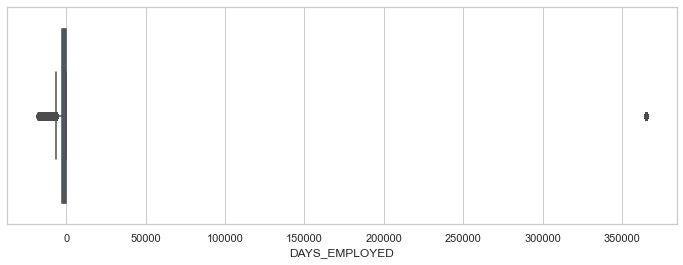

In [258]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,4))
ax = sns.boxplot(x=numeric_df["DAYS_EMPLOYED"])

In [236]:
outliers_days_employed = app_train[
    (app_train ["DAYS_EMPLOYED"] > 350000)
].index

In [237]:
len(outliers_days_employed)

55374

In [238]:
app_train["NAME_INCOME_TYPE"].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

It seems that outliers in the days employed column are actualy people who receive constant income but not from the employment, it is people who are pensioners. Moreover, there are more than 55k of them, which is about 18% of data. It means that these data should not be considered as outliers.

In [240]:
numeric_df.OWN_CAR_AGE.describe()

count    104582.000000
mean         12.061091
std          11.944812
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

OWN_CAR_AGE has a lot of missing values. It is probably due to the fact that many people don't own the car. So I will update missing values accordingly: with 0 if no car, and 12 (mean value) if owns a car. 

In [7]:
def impute_car_age(dataframe):
    numeric_df = dataframe.select_dtypes(exclude="object")
    mask = (numeric_df["OWN_CAR_AGE"].isnull()) & (numeric_df["FLAG_OWN_CAR"] == 0)
    numeric_df.loc[mask, ["OWN_CAR_AGE"]] = 0
    
    numeric_df["OWN_CAR_AGE"] = numeric_df["OWN_CAR_AGE"].fillna(12)
    
    return numeric_df

### Missing values

In [71]:
app_train_nan = percent_missing(numeric_df)

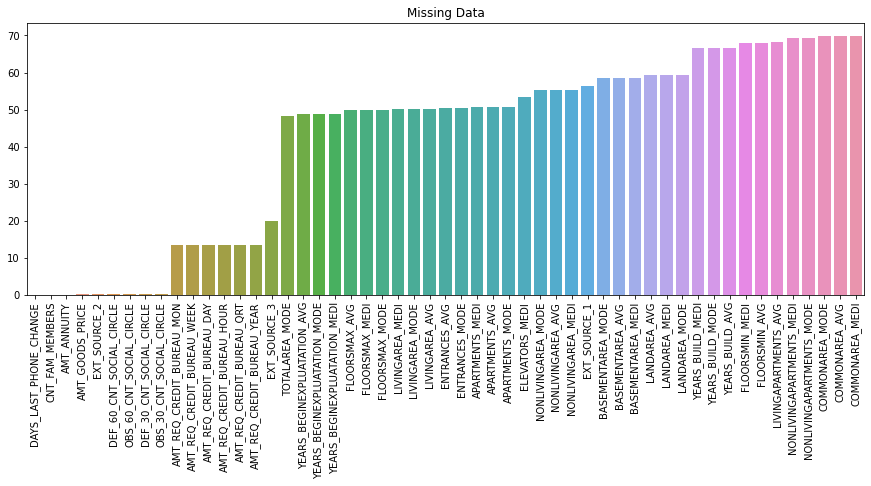

In [72]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.title("Missing Data")

ax = sns.barplot(x=app_train_nan.index, y=app_train_nan)

Most missing values are in the columns about the place person lives. Imputing it with mean or median can negatively impact results, so it is worth trying to drop these columns and see if accuracy increases. 

In [8]:
housing_info = [
    "TOTALAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BEGINEXPLUATATION_AVG",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMAX_AVG",
    "FLOORSMAX_MODE",
    "LIVINGAREA_MEDI",
    "LIVINGAREA_MODE",
    "LIVINGAREA_AVG",
    "ENTRANCES_AVG",
    "ENTRANCES_MODE",
    "APARTMENTS_AVG",
    "APARTMENTS_MODE",
    "APARTMENTS_MEDI",
    "ELEVATORS_MEDI",
    "NONLIVINGAREA_AVG",
    "NONLIVINGAREA_MEDI",
    "NONLIVINGAREA_MODE",
    "BASEMENTAREA_MODE",
    "BASEMENTAREA_MEDI",
    "BASEMENTAREA_AVG",
    "LANDAREA_MODE",
    "LANDAREA_AVG",
    "LANDAREA_MEDI",
    "YEARS_BUILD_AVG",
    "YEARS_BUILD_MODE",
    "YEARS_BUILD_MEDI",
    "FLOORSMIN_MEDI",
    "FLOORSMIN_AVG",
    "LIVINGAPARTMENTS_AVG",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAPARTMENTS_MEDI",
    "COMMONAREA_MEDI",
    "COMMONAREA_MODE",
    "COMMONAREA_AVG",
]



To this point, application dataframes can be cleaned by calling the function below:

In [9]:
def get_cleaned_dataframe(dataframe):
    copy_df = dataframe.copy()
    label_encoded_df = encode_features(copy_df)
    droped_columns_df = label_encoded_df.drop(columns_to_drop, axis=1)
    objects_df = clean_object_features(droped_columns_df, object_columns)
    numeric_df = impute_car_age(droped_columns_df)
    all_df = pd.concat([numeric_df, objects_df], axis=1)
    all_df_final = DataFrameImputer().fit_transform(all_df)
    return all_df_final

In [10]:
app_train = get_cleaned_dataframe(application_train)

In [11]:
app_test = get_cleaned_dataframe(application_test)

### Intermediate check

In [363]:
app_train_no_house = app_train_final.drop(housing_info, axis=1)
no_housing = app_train_no_house.columns[2:]

In [364]:
train_sample = app_train_final.sample(frac=0.01, replace=True, random_state=42)
features_list = list(train_sample.columns[2:])

X_app_train = train_sample[train_sample.columns[2:]].values
X_no_housing = train_sample[no_housing].values
y = train_sample["TARGET"].to_numpy()

In [367]:
lgb = LGBMClassifier(random_state=RANDOM, objective="binary", verbose=-1)
xgb = XGBClassifier(random_state=RANDOM)
cbc = CatBoostClassifier(random_state=RANDOM, verbose=0)

scores_all = cross_val_score(
    cbc, X_app_train, y, cv=5, scoring="roc_auc", error_score="raise"
)
scores_no_house = cross_val_score(
    cbc, X_no_housing, y, cv=5, scoring="roc_auc", error_score="raise"
)

print("CV_all mean score all:", round(scores_all.mean(), 3))
print("CV_all mean score no housing:", round(scores_no_house.mean(), 3))

CV_all mean score all: 0.746
CV_all mean score no housing: 0.745


In [26]:
intermediate_model_results = {
    "model": ["LightGBM", "XGBClassifier", "CatBoostClassifier",],
    "all selected features": [0.733, 0.714, 0.748],
    "all selected, no median impute": [0.723, 0.713, 0.746],
    "all selected, no median and housing": [0.728, 0.714, 0.745],
    "all selected, median impute, no car age update": [0.724, 0.720, 0.746],
    "all selected, median impute, no housing, no car age update": [0.727, 0.719, 0.745],
    "with new features": [0.729, 0.720, 0.75],
    "with new features, no housing": [0.727, 0.719, 0.745],
    "plus bureau info": [0.738, 0.729, 0.752],
    "plus bureau, minus housing": [0.738, 0.718, 0.750],
    "plus POS": [0.734, 0.731, 0.751],
    "plus POS, minus housing": [0.737, 0.726, 0.752],
    "bureau and CC balance": [0.735, 0.732, 0.752],
    "bureay and CC balance, no housing": [0.736, 0.718, 0.766],
    "bureau, POS and CC balance": [0.751, 0.727, 0.756],
    "bureau, POS and CC balance, no housing": [0.746, 0.730, 0.759],
    "bureau and previous app": [0.745, 0.733, 0.762],
    "bureau and previous app, no housing": [0.741, 0.716, 0.766],
    "bureau, CC and previous app": [0.740, 0.746, 0.761],
    "bureau, CC and previous app, no housing": [0.735, 0.728, 0.760],
    "bureau, POS, CC and previous app": [0.739, 0.729, 0.759],
    "bureau, POS, CC and previous app, no housing": [0.736, 0.742, 0.763],
    "bureau and installment": [0.733, 0.722, 0.755],
    "bureau and installment, no housing": [0.726, 0.73, 0.761],
    "bureau, previous_app and install": [0.733, 0.723, 0.763],
    "bureau, previous_app and install, no housing": [0.736, 0.725, 0.763],
    "bureau, CC and install": [0.747, 0.744, 0.761],
    "bureau, CC and install, no housing": [0.753, 0.739, 0.764],
    "bureau, POS and install": [0.739, 0.723, 0.754],
    "bureau, POS and install, no housing": [0.743, 0.726, 0.755],
    "all files": [0.748, 0.733, 0.761],
    "all files, no housing": [0.739, 0.742, 0.765],
}

In [27]:
intermediate_model_results = pd.DataFrame.from_dict(intermediate_model_results)

In [28]:
interm_results = intermediate_model_results.T
interm_results.columns = interm_results.iloc[0]

interm_results = interm_results.drop(["model"], axis=0)

interm_results["mean"] = interm_results.mean(axis=1)

In [32]:
interm_results.sort_values(by=["mean"], ascending=False)

model,LightGBM,XGBClassifier,CatBoostClassifier,mean
"bureau, CC and install, no housing",0.753,0.739,0.764,0.752000
"bureau, CC and install",0.747,0.744,0.761,0.750667
"bureau, CC and previous app",0.74,0.746,0.761,0.749000
"all files, no housing",0.739,0.742,0.765,0.748667
all files,0.748,0.733,0.761,0.747333
"bureau, POS, CC and previous app, no housing",0.736,0.742,0.763,0.747000
bureau and previous app,0.745,0.733,0.762,0.746667
"bureau, POS and CC balance, no housing",0.746,0.73,0.759,0.745000
"bureau, POS and CC balance",0.751,0.727,0.756,0.744667
"bureau, POS, CC and previous app",0.739,0.729,0.759,0.742333


I couldn't recreate results from baseline because different sample was taken from the dataset, but it seems that housing information do not play a huge impact on the score (negatively or positively).

### New features

In [147]:
corr_with_target = app_train_selected.corrwith(app_train_selected["TARGET"]).sort_values()

In [148]:
corr_with_target = corr_with_target.to_frame()

In [ ]:
pd.set_option('display.max_rows', 500)
corr_with_target 

- EXT_SOURCE_2	__-0.160303__
- EXT_SOURCE_3	__-0.157397__
- EXT_SOURCE_1	__-0.099152__
- NAME_EDUCATION_TYPE_Higher education	__-0.056593__
- NAME_INCOME_TYPE_Pensioner	__-0.046209__
- ORGANIZATION_TYPE_XNA	__-0.045987__
- DAYS_EMPLOYED	__-0.044932__

In [13]:
def add_new_features(original_df):
    dataframe = original_df.copy()
    dataframe["Interest_Rate"] = dataframe["AMT_CREDIT"] / dataframe["AMT_ANNUITY"]
    dataframe["Ratio_Income&Credit"] = (
        dataframe["AMT_CREDIT"] / dataframe["AMT_INCOME_TOTAL"]
    )
    dataframe["Region_ratings_sum"] = (
        dataframe["REGION_RATING_CLIENT_W_CITY"] + dataframe["REGION_RATING_CLIENT"]
    )
    dataframe["Region_ratings"] = (
        dataframe["REGION_RATING_CLIENT_W_CITY"] * dataframe["REGION_RATING_CLIENT"]
    )
    dataframe["Age_gender"] = dataframe["DAYS_BIRTH"] * dataframe["CODE_GENDER"]
    dataframe["Social_circle_sum"] = (
        dataframe["DEF_30_CNT_SOCIAL_CIRCLE"] + dataframe["DEF_60_CNT_SOCIAL_CIRCLE"]
    )
    dataframe["Social_circle"] = (
        dataframe["DEF_30_CNT_SOCIAL_CIRCLE"] * dataframe["DEF_60_CNT_SOCIAL_CIRCLE"]
    )
    dataframe["Working_age"] = dataframe["DAYS_BIRTH"] + dataframe["DAYS_EMPLOYED"]
    dataframe["Pensioner_XNA"] = (
        dataframe["NAME_INCOME_TYPE_Pensioner"] + dataframe["ORGANIZATION_TYPE_XNA"]
    )
    dataframe["EXT_SOURCE_all"] = (
        dataframe["EXT_SOURCE_1"]
        + dataframe["EXT_SOURCE_2"]
        + dataframe["EXT_SOURCE_3"]
    )
    return dataframe

In [14]:
train_with_new_features = add_new_features(app_train)
test_with_new_features = add_new_features(app_test)

New features improved the score on all trials, so decided to be kept.

### Features from additional files

#### Bureau information

In [15]:
bureau_balance_status = bureau_balance[["SK_ID_BUREAU", "STATUS"]]
bureau_balance_status = bureau_balance_status.replace({'C': 0})

bureau_balance_status = bureau_balance_status[bureau_balance_status.STATUS != "X"]
bureau_balance_status["STATUS"] = pd.to_numeric(bureau_balance_status["STATUS"])

In [16]:
bureau_balance_status_sum = bureau_balance_status.groupby(
    by=bureau_balance_status.SK_ID_BUREAU
).sum()
bureau_with_status = pd.merge(bureau, bureau_balance_status_sum, on="SK_ID_BUREAU")

In [17]:
bureau_with_status_imputed = DataFrameImputer().fit_transform(bureau_with_status)
bureau_with_status_imputed_enc = pd.get_dummies(
    bureau_with_status_imputed, drop_first=True
)

In [18]:
bureau_balance_status_sum = bureau_with_status_imputed_enc.groupby(
    by=bureau_with_status_imputed_enc.SK_ID_CURR
).sum()
bureau_balance_status_sum = bureau_balance_status_sum.drop(["SK_ID_BUREAU"], axis=1)

In [19]:
app_train_and_bureau = train_with_new_features.merge(
    bureau_balance_status_sum, on="SK_ID_CURR", how="left"
)

In [20]:
app_train_and_bureau["no_bureau_info"] = (
    app_train_and_bureau.isnull().any(axis=1).astype(int)
)
app_train_and_bureau_imp = DataFrameImputer().fit_transform(app_train_and_bureau)

In [21]:
app_test_and_bureau = test_with_new_features.merge(
    bureau_balance_status_sum, on="SK_ID_CURR", how="left"
)

app_test_and_bureau["no_bureau_info"] = (
    app_test_and_bureau.isnull().any(axis=1).astype(int)
)
app_test_and_bureau_imp = DataFrameImputer().fit_transform(app_test_and_bureau)

Bureau information increased model's accuraccy. File should be kept. 

#### POS_CASH_balance file

In [22]:
POS_CASH_balance_enc = pd.get_dummies(POS_CASH_balance)
POS_CASH_balance_enc = POS_CASH_balance_enc.drop("SK_ID_PREV", axis=1)

In [23]:
POS_CASH_balance_SK_ID_mean = POS_CASH_balance_enc.groupby("SK_ID_CURR").agg(
    {
        "MONTHS_BALANCE": "mean",
        "CNT_INSTALMENT": "mean",
        "CNT_INSTALMENT_FUTURE": "mean",
    }
)

POS_CASH_balance_SK_ID_mean.columns = [
    "MONTHS_BALANCE_mean",
    "CNT_INSTALMENT_mean",
    "CNT_INSTALMENT_FUTURE_mean",
]

In [24]:
POS_CASH_balance_enc_grouped = POS_CASH_balance_enc.groupby(
    by=POS_CASH_balance_enc.SK_ID_CURR
).sum()

In [25]:
POS_CASH_balance_enc_all = pd.concat(
    [POS_CASH_balance_enc_grouped, POS_CASH_balance_SK_ID_mean], axis=1
)

In [26]:
POS_CASH_balance_enc_all = DataFrameImputer().fit_transform(POS_CASH_balance_enc_all)

In [27]:
app_train_bureau_POS = app_train_and_bureau.merge(
    POS_CASH_balance_enc_all, on="SK_ID_CURR", how="left"
)

In [28]:
app_test_bureau_POS = app_test_and_bureau.merge(
    POS_CASH_balance_enc_all, on="SK_ID_CURR", how="left"
)

Results are ambiguous. XGB Clasifier results improve, LGBM - decrease and CatBoost more or less neutral. 

#### Credit card balance file

In [29]:
credit_card_balance_imputed = DataFrameImputer().fit_transform(credit_card_balance)

In [30]:
credit_card_balance_enc = pd.get_dummies(credit_card_balance)
credit_card_balance_enc = credit_card_balance_enc.drop("SK_ID_PREV", axis=1)

In [31]:
credit_card_balance_numeric = credit_card_balance_imputed.select_dtypes(
    include=["int64", "float64"]
)

In [32]:
credit_card_balance_categorical = pd.get_dummies(
    credit_card_balance_imputed["NAME_CONTRACT_STATUS"]
)

In [33]:
credit_card_balance_categorical["SK_ID_CURR"] = credit_card_balance_imputed[
    "SK_ID_CURR"
]

In [34]:
credit_card_balance_categories_sum = credit_card_balance_categorical.groupby(
    by=credit_card_balance_categorical.SK_ID_CURR
).sum()

In [35]:
credit_card_balance_numeric_grouped = credit_card_balance_numeric.groupby(
    by=credit_card_balance_numeric.SK_ID_CURR
).mean()

credit_card_balance_numeric_grouped = credit_card_balance_numeric_grouped.drop(
    ["SK_ID_PREV"], axis=1
)

In [36]:
credit_card_balance_all = pd.concat(
    [credit_card_balance_numeric_grouped, credit_card_balance_categories_sum], axis=1
)

In [37]:
app_train_bureau_CC = app_train_and_bureau.merge(
    credit_card_balance_all, on="SK_ID_CURR", how="left"
)

app_test_bureau_CC = app_test_and_bureau.merge(
    credit_card_balance_all, on="SK_ID_CURR", how="left"
)

In [38]:
app_train_bureau_POS_CC = app_train_bureau_POS.merge(
    credit_card_balance_all, on="SK_ID_CURR", how="left"
)

app_test_bureau_POS_CC = app_test_bureau_POS.merge(
    credit_card_balance_all, on="SK_ID_CURR", how="left"
)

CC balance at some cases had great results, while on other trials were mostly neutral.

#### Previous application's info

In [39]:
le = LabelEncoder()
previous_application[["FLAG_LAST_APPL_PER_CONTRACT"]] = previous_application[
    ["FLAG_LAST_APPL_PER_CONTRACT"]
].apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type="expand")

In [41]:
features_to_other = [
    "NAME_CASH_LOAN_PURPOSE",
    "NAME_GOODS_CATEGORY",
    "NAME_SELLER_INDUSTRY",
]
previous_app_upd_feat = change_to_other(previous_application, features_to_other, 10000)

In [42]:
previous_app_imputed = DataFrameImputer().fit_transform(previous_app_upd_feat)
previous_app_imputed_enc = pd.get_dummies(
    previous_app_imputed, drop_first=True
)

In [43]:
previous_app_imputed_numeric = previous_app_imputed.select_dtypes(
    include=["int64", "float64"]
)

In [44]:
previous_app_imputed_cat = previous_app_imputed.select_dtypes(
    exclude=["int64", "float64"]
)
previous_app_imputed_cat_enc = pd.get_dummies(previous_app_imputed_cat)

In [45]:
features_to_sum = [
    "AMT_ANNUITY",
    "AMT_APPLICATION",
    "AMT_CREDIT",
    "AMT_DOWN_PAYMENT",
    "AMT_GOODS_PRICE",
    "NFLAG_INSURED_ON_APPROVAL",
]

In [46]:
previous_app_to_sum = previous_app_imputed_numeric[features_to_sum]
previous_app_to_sum["SK_ID_CURR"] = previous_app_imputed_numeric["SK_ID_CURR"]

In [47]:
previous_app_sum = pd.concat(
    [previous_app_imputed_cat_enc, previous_app_to_sum], axis=1
)

In [48]:
previous_app_grouped_sum = previous_app_sum.groupby(
    by=previous_app_sum.SK_ID_CURR
).sum()

In [49]:
previous_app_to_mean = previous_app_imputed_numeric.drop(features_to_sum, axis=1)
previous_app_to_mean = previous_app_to_mean.drop(["SK_ID_PREV"], axis=1)

In [50]:
previous_app_grouped_mean = previous_app_to_mean.groupby(
    by=previous_app_to_mean.SK_ID_CURR
).mean()

In [51]:
previous_app_all = pd.concat(
    [previous_app_grouped_mean, previous_app_grouped_sum], axis=1
)

In [52]:
app_train_bureau_previous_app = app_train_and_bureau.merge(
    previous_app_all, on="SK_ID_CURR", how="left"
)

In [53]:
app_train_bureau_CC_previous_app = app_train_bureau_CC.merge(
    previous_app_all, on="SK_ID_CURR", how="left"
)

In [54]:
app_train_bureau_POS_CC_previous_app = app_train_bureau_POS_CC.merge(
    previous_app_all, on="SK_ID_CURR", how="left"
)

In [55]:
app_test_bureau_previous_app = app_test_and_bureau.merge(
    previous_app_all, on="SK_ID_CURR", how="left"
)
app_test_bureau_CC_previous_app = app_test_bureau_CC.merge(
    previous_app_all, on="SK_ID_CURR", how="left"
)
app_test_bureau_POS_CC_previous_app = app_test_bureau_POS_CC.merge(
    previous_app_all, on="SK_ID_CURR", how="left"
)

Previous application's info increased accuracy of all models. 

#### Installments_payments_all

In [56]:
installments_payments_to_sum = installments_payments[
    ["SK_ID_CURR", "AMT_INSTALMENT", "AMT_PAYMENT"]
]
installments_payments_to_mean = installments_payments.drop(
    ["AMT_INSTALMENT", "AMT_PAYMENT", "SK_ID_PREV"], axis=1
)

In [57]:
installments_payments_sum = installments_payments_to_sum.groupby(
    by=installments_payments_to_sum.SK_ID_CURR
).sum()

In [58]:
installments_payments_mean = installments_payments_to_mean.groupby(
    by=installments_payments_to_mean.SK_ID_CURR
).mean()

In [59]:
installments_payments_all = pd.concat(
    [installments_payments_sum, installments_payments_mean], axis=1
)
installments_payments_all = DataFrameImputer().fit_transform(installments_payments_all)

In [60]:
app_train_bureau_install = app_train_and_bureau.merge(
    installments_payments_all, on="SK_ID_CURR", how="left"
)

In [61]:
app_train_bureau_previous_app_install = app_train_bureau_previous_app.merge(
    installments_payments_all, on="SK_ID_CURR", how="left"
)

In [62]:
app_train_bureau_POS_install = app_train_bureau_POS.merge(
    installments_payments_all, on="SK_ID_CURR", how="left"
)

In [63]:
app_train_bureau_CC_install = app_train_bureau_CC.merge(
    installments_payments_all, on="SK_ID_CURR", how="left"
)

In [64]:
all_files = app_train_bureau_POS_CC_previous_app.merge(
    installments_payments_all, on="SK_ID_CURR", how="left"
)

In [65]:
all_files = all_files.fillna(0)

In [66]:
app_test_bureau_install = app_test_and_bureau.merge(
    installments_payments_all, on="SK_ID_CURR", how="left"
)
app_test_bureau_previous_app_install = app_test_bureau_previous_app.merge(
    installments_payments_all, on="SK_ID_CURR", how="left"
)
app_test_bureau_POS_install = app_test_bureau_POS.merge(
    installments_payments_all, on="SK_ID_CURR", how="left"
)
app_test_bureau_CC_install = app_test_bureau_CC.merge(
    installments_payments_all, on="SK_ID_CURR", how="left"
)
all_test_files = app_test_bureau_POS_CC_previous_app.merge(
    installments_payments_all, on="SK_ID_CURR", how="left"
)

In [67]:
all_test_files = all_test_files.fillna(0)

In [68]:
all_test_files_no_housing = all_test_files.drop(housing_info, axis=1)

Taking the file "Installments_payments_all" alone, results were vey ambiguous - some models increased their score, while others dropped. Nevertheless, all files seems to be giving great results, so this file could be useful. 

## Modelling

### Preparation

#### Naming and preparing dataframes

According to the intermediate results table, the best dataframes were: 

In [72]:
app_train_bureau_CC_no_housing = app_train_bureau_CC.drop(housing_info, axis=1)
app_train_bureau_CC_no_housing.name = "bureau, CC, no housing"

app_train_bureau_app_no_housing = app_train_bureau_previous_app.drop(
    housing_info, axis=1
)
app_train_bureau_app_no_housing.name = "bureau, app, no housing"

app_train_bureau_POS_CC.name = "bureau, CC and POS"

app_train_bureau_CC_previous_app.name = "bureau, CC and app"

app_train_bureau_CC_install.name = "bureau, CC and installment"

app_train_bureau_CC_install_no_housing = app_train_bureau_CC_install.drop(
    housing_info, axis=1
)
app_train_bureau_CC_install_no_housing.name = "bureau, CC and installment, no housing"

all_files.name = "all files"

all_files_no_housing = all_files.drop(housing_info, axis=1)
all_files_no_housing.name = "all files, no housing"

In [134]:
best_dataframes = [
    app_train_bureau_CC_no_housing,
    app_train_bureau_app_no_housing,
    app_train_bureau_POS_CC,
    app_train_bureau_CC_previous_app,
    app_train_bureau_CC_install,
    app_train_bureau_CC_install_no_housing,
    all_files,
    all_files_no_housing,
]

#### Naming and setting base hyperparameters for models

In [202]:
lgb = LGBMClassifier(random_state=RANDOM, objective="binary", verbose=-1)
# LGBMClassifier does not have an attribute name
lgb.name = "LightGBM"

xgb = XGBClassifier(random_state=RANDOM, verbosity=0, nthread=4)
xgb.name = "XGB"

cbc = CatBoostClassifier(random_state=RANDOM, verbose=0)
cbc.name = "CatBoost"

models = [lgb, xgb, cbc]

#### Creating hyperparameters dictionaries for tuning

In [119]:
xgb_params = dict(
    model__max_depth=list(range(2, 6)),
    model__min_child_weight=list(range(1, 20)),
    model__subsample=[0.5, 0.6, 0.7, 0.8, 0.9],
    model__gamma=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    model__colsample_bytree=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    model__reg_lambda=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
    model__reg_alpha=[1e-5, 1e-2, 0.1, 1, 100],
    model__learning_rate=[0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.13, 0.16, 0.19],
    model__n_estimators=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000],
)

In [146]:
lgb_params = dict(
    model__max_depth=list(range(2, 6)),
    model__num_leaves=[6, 8, 12, 16, 32, 48, 100, 130, 150, 180, 200],
    model__min_data_in_leaf=[5, 10, 25, 50, 75, 100, 150],
    model__feature_fraction=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    model__subsample=[0.5, 0.6, 0.7, 0.8, 0.9],
    model__learning_rate=[0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.13, 0.16, 0.19],
    model__n_estimators=[200, 300, 500, 700],
)

In [121]:
cbc_params = dict(
    model__learning_rate=[0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.13, 0.16, 0.19],
    model__max_depth=list(range(2, 6)),
    model__subsample=[0.5, 0.6, 0.7, 0.8, 0.9],
    model__n_estimators=[200, 300, 500, 700]
)

#### Calculating results

In [212]:
# results = check_dataframes(best_dataframes, models)
# results.to_csv("modeling_results.csv")
modeling_results = pd.read_csv("modeling_results.csv")
modeling_results = modeling_results.drop(["Unnamed: 0"], axis=1)
modeling_results.sort_values(by="validation score", ascending=False)

,best_params,dataframe,model,time,training score,validation score
23,"{'model__subsample': 0.9, 'model__n_estimators...","all files, no housing",<catboost.core.CatBoostClassifier object at 0x...,3.3571,0.879,0.811
17,"{'model__subsample': 0.9, 'model__n_estimators...","bureau, CC and installment, no housing",<catboost.core.CatBoostClassifier object at 0x...,2.3152,0.877,0.801
20,"{'model__subsample': 0.9, 'model__n_estimators...",all files,<catboost.core.CatBoostClassifier object at 0x...,4.0779,0.879,0.799
5,"{'model__subsample': 0.9, 'model__n_estimators...","bureau, app, no housing",<catboost.core.CatBoostClassifier object at 0x...,2.9332,0.863,0.797
21,"{'model__subsample': 0.7, 'model__num_leaves':...","all files, no housing","LGBMClassifier(objective='binary', random_stat...",0.3008,0.841,0.793
2,"{'model__subsample': 0.9, 'model__n_estimators...","bureau, CC, no housing",<catboost.core.CatBoostClassifier object at 0x...,3.0429,0.871,0.791
18,"{'model__subsample': 0.7, 'model__num_leaves':...",all files,"LGBMClassifier(objective='binary', random_stat...",0.3528,0.842,0.791
11,"{'model__subsample': 0.9, 'model__n_estimators...","bureau, CC and app",<catboost.core.CatBoostClassifier object at 0x...,3.6597,0.871,0.788
8,"{'model__subsample': 0.5, 'model__n_estimators...","bureau, CC and POS",<catboost.core.CatBoostClassifier object at 0x...,2.7971,0.914,0.786
12,"{'model__subsample': 0.8, 'model__num_leaves':...","bureau, CC and installment","LGBMClassifier(objective='binary', random_stat...",0.3617,0.929,0.784


XGBClassifier results were unexpectedly bad. It seems that randomized search CV failed to find the best parameters because manual testings brings much better results, e.g.: 

In [274]:
train_sample = app_train_bureau_POS_CC.sample(frac=0.01, replace=True, random_state=42)
features_list = list(train_sample.columns[2:])

X = train_sample[train_sample.columns[2:]].values
y = train_sample["TARGET"].to_numpy()

In [275]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [276]:
# app_train_bureau_POS_CC dataframe

xgb = XGBClassifier(
    verbosity=0,
    nthread=4,
    colsample_bytree=0.4,
    gamma=0.25,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=3,
    n_estimators=500,
    reg_alpha=1e-05,
    reg_lambda=1.5,
    subsample=0.5,
)

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict_proba(X_train)
y_pred = xgb.predict_proba(X_test)

print("Training ROC AUC score is", roc_auc_score(y_train, y_pred_train[:, 1]))
print("Validation ROC AUC score is", roc_auc_score(y_test, y_pred[:, 1]))

Training mean squared error is 0.9409344126343115
Validation mean squared error is 0.7987797086634295


In [277]:
app_bureau_POS_CC_model_data = app_train_bureau_POS_CC.drop(
    ["SK_ID_CURR", "TARGET"], axis=1
)

In [278]:
X = app_bureau_POS_CC_model_data.values
y = app_train_bureau_POS_CC["TARGET"].to_numpy()

In [279]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [280]:
xgb = XGBClassifier(
    verbosity=0,
    nthread=4,
    colsample_bytree=0.4,
    gamma=0.25,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=3,
    n_estimators=500,
    reg_alpha=1e-05,
    reg_lambda=1.5,
    subsample=0.5,
)

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict_proba(X_train)
y_pred = xgb.predict_proba(X_test)

print("Training ROC AUC score is", roc_auc_score(y_train, y_pred_train[:, 1]))
print("Validation ROC AUC score is", roc_auc_score(y_test, y_pred[:, 1]))

Training mean squared error is 0.7636852359765878
Validation mean squared error is 0.7581847656391104


### Kaggle competition

For kaggle competition I will try to use all 3 models with supposingly the best hyperparameters and suggested dataframes. 

In [73]:
X = train_with_more_features_data.values
y = train_with_more_features["TARGET"].to_numpy()

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Best model with CatBoostClassifier

In [348]:
# all files with all features
cbc = CatBoostClassifier(random_state=RANDOM, verbose=0, learning_rate=0.1)

cbc.fit(X_train, y_train)
y_pred_train = cbc.predict_proba(X_train)
y_pred = cbc.predict_proba(X_test)

print("Training ROC AUC score is", roc_auc_score(y_train, y_pred_train[:, 1]))
print("Validation ROC AUC score is", roc_auc_score(y_test, y_pred[:, 1]))

Training mean squared error is 0.8433302564527857
Validation mean squared error is 0.7897655711256724


In [361]:
# all files, all features, params from RandomizedCVSearch
cbc = CatBoostClassifier(
    random_state=RANDOM,
    verbose=0,
    learning_rate=0.05,
    max_depth=4,
    n_estimators=2000,
    reg_lambda=3.5,
    subsample=0.8,
)

cbc.fit(X_train, y_train)
y_pred_train = cbc.predict_proba(X_train)
y_pred = cbc.predict_proba(X_test)

print("Training ROC AUC score is", roc_auc_score(y_train, y_pred_train[:, 1]))
print("Validation ROC AUC score is", roc_auc_score(y_test, y_pred[:, 1]))

Training mean squared error is 0.8139940080903971
Validation mean squared error is 0.791442874271711


#### Best model with LGBMClassifier

In [294]:
# all files, all features, no housing
lgb = LGBMClassifier(
    random_state=RANDOM,
    objective="binary",
    verbose=-1,
    num_leaves=16,
    n_estimators=700,
    min_data_in_leaf=25,
    max_depth=3,
    max_bin=255,
    feature_fraction=0.7,
    boosting_type="gbdt",
)


lgb.fit(X_train, y_train)
y_pred_train = lgb.predict_proba(X_train)
y_pred = lgb.predict_proba(X_test)

print('Training score is', roc_auc_score(y_train, y_pred_train[:, 1]))
print('Validation score is', roc_auc_score(y_test, y_pred[:, 1]))

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
Training score is 0.8225316806068509
Validation score is 0.789918244970147


#### Best model with XGBClassifier

In [355]:
# all files, all features, best params

xgb = XGBClassifier(
    verbosity=0,
    nthread=4,
    colsample_bytree=0.4,
    gamma=0.05,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=8,
    n_estimators=900,
    reg_alpha=100,
    reg_lambda=1,
    subsample=0.7,
)

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict_proba(X_train)
y_pred = xgb.predict_proba(X_test)

print('Training mean squared error is', roc_auc_score(y_train, y_pred_train[:, 1]))
print('Validation mean squared error is', roc_auc_score(y_test, y_pred[:, 1]))

Training mean squared error is 0.8047801295504162
Validation mean squared error is 0.788722958376467


#### Data Sampling

In [107]:
over = RandomOverSampler(sampling_strategy=0.1)

X, y = over.fit_resample(X, y)

under = RandomUnderSampler(sampling_strategy=0.5)

X, y = under.fit_resample(X, y)

I tried all possible scenarios: using only oversampling, only undersampling and their combination, but nothing improved the score, because models were overfitting data. Example: 

In [136]:
cbc = CatBoostClassifier(
    random_state=RANDOM,
    verbose=0,
    class_weights={0: 0.5472361809045226, 1: 0.45276381909547736},
    reg_lambda=2,
    learning_rate=0.15,
    max_depth=7,
    n_estimators=1000,
    subsample=0.7,
)

cbc.fit(X_train, y_train)
y_pred_train = cbc.predict_proba(X_train)
y_pred = cbc.predict_proba(X_test)

print("Training mean squared error is", roc_auc_score(y_train, y_pred_train[:, 1]))
print("Validation mean squared error is", roc_auc_score(y_test, y_pred[:, 1]))

Training mean squared error is 0.9600344365991076
Validation mean squared error is 0.7926250273787983


#### Model's hyperparameters optimization

To find the best hyperparameters, for CatBoost and XGB classifiers I used RandomSearchCV, while for LightGBM I also tried optuna. 

##### Optuna for LightGBM

In [105]:
def lgbtuna(trial, X=X, y=y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=RANDOM
    )

    n_estimators = trial.suggest_int("n_estimators", 100, 5000)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 1, 20)
    num_leaves = trial.suggest_int("num_leaves", 2, 256)
    feature_fraction = (trial.suggest_uniform("feature_fraction", 0.4, 1.0),)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    lambda_l1 = trial.suggest_loguniform("lambda_l1", 1e-8, 10.0)
    lambda_l2 = trial.suggest_loguniform("lambda_l2", 1e-8, 10.0)
    min_child_weight = trial.suggest_int("min_child_samples", 1, 10)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)

    lgbm_tuna = lgbm.LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        feature_fraction=feature_fraction,
        subsample=subsample,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        min_child_weight=min_child_weight,
        min_child_samples=min_child_samples,
        verbose=-1,
    )

    lgbm_tuna.fit(X_train, y_train)

    y_pred_train = lgbm_tuna.predict_proba(X_train)
    y_pred = lgbm_tuna.predict_proba(X_test)

    return -roc_auc_score(y_test, y_pred[:, 1])

In [ ]:
%time 
lgbm_study = optuna.create_study()
lgbm_study.optimize(lgbtuna, n_trials=100, n_jobs=-1, gc_after_trial=True)

print('Best score:', lgbm_study.best_value)
print('Best trial:', lgbm_study.best_params)

[I 2021-08-07 13:13:41,706] Trial 9 finished with value: -0.7906956751470674 and parameters: {'n_estimators': 3373, 'learning_rate': 0.009164447496968044, 'max_depth': 4, 'num_leaves': 117, 'feature_fraction': 0.40539349913462347, 'subsample': 0.9508225056823643, 'lambda_l1': 4.633450011240734e-08, 'lambda_l2': 8.64307071096595, 'min_child_samples': 4}. Best is trial 9 with value: -0.7906956751470674.

In [155]:
lgb = LGBMClassifier(
    random_state=RANDOM,
    verbose=-1,
    n_estimators=3373,  
    learning_rate=0.009164447496968044,
    max_depth=4,
    num_leaves=117,
    feature_fraction=0.40539349913462347,
    subsample=0.9508225056823643,
    lambda_l1=4.633450011240734e-08,
    lambda_l2=8.64307071096595,
    min_child_samples=4
)


lgb.fit(X_train, y_train)
y_pred_train = lgb.predict_proba(X_train)
y_pred = lgb.predict_proba(X_test)

print('Training score is', roc_auc_score(y_train, y_pred_train[:, 1]))
print('Validation score is', roc_auc_score(y_test, y_pred[:, 1]))

[LightGBM] [Warning] lambda_l1 is set=4.633450011240734e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.633450011240734e-08
[LightGBM] [Warning] feature_fraction is set=0.40539349913462347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40539349913462347
[LightGBM] [Warning] lambda_l2 is set=8.64307071096595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.64307071096595
Training score is 0.817917019777076
Validation score is 0.7912242264285007


##### RandomizedSearchCV for CatBoostClassifier

In [118]:
cbc = CatBoostClassifier(random_state=RANDOM, verbose=0)

weights = np.linspace(0.0, 0.99, 200)

param_dist = {
    "learning_rate": np.linspace(0, 0.2, 5),
    "max_depth": sp_randInt(3, 10),
    "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000],
    "reg_lambda": [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
    "class_weights": [{0: x, 1: 1.0 - x} for x in weights],
}

rscv = RandomizedSearchCV(cbc, param_dist, scoring="roc_auc", cv=5)

rscv.fit(X_train, y_train)
print(rscv.best_score_)
print(rscv.best_params_)

0.7861628849733776
{'class_weights': {0: 0.5223618090452261, 1: 0.4776381909547739}, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 800, 'reg_lambda': 0.5, 'subsample': 0.7}


In [246]:
cbc = CatBoostClassifier(
    random_state=RANDOM,
    verbose=0,
    learning_rate=0.01,
    max_depth=4,
    n_estimators=500,
    subsample=0.9,
)

cbc.fit(X_train, y_train)
y_pred_train = cbc.predict_proba(X_train)
y_pred = cbc.predict_proba(X_test)

print("Training ROC AUC score is", roc_auc_score(y_train, y_pred_train[:, 1]))
print("Validation ROC AUC score is", roc_auc_score(y_test, y_pred[:, 1]))

Training mean squared error is 0.8791352671810775
Validation mean squared error is 0.8107270636340403


##### RandomizedSearchCV for XGBClassifier

In [353]:
xgb = XGBClassifier(verbosity=0, nthread=4)

parameter_grid = {
    "max_depth": list(range(2, 6)),
    "weights": [1, 10, 25, 50, 75, 99, 100, 1000],
    "min_child_weight": list(range(1, 20)),
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
    "gamma": [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    "colsample_bytree": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "reg_lambda": [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 100],
    "learning_rate": [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.13, 0.16, 0.19,],
    "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000],
}

grid_search = RandomizedSearchCV(xgb, parameter_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train, y_train)
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

Best score: 0.786694249970034
Best parameters: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 100, 'n_estimators': 900, 'min_child_weight': 8, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.05, 'colsample_bytree': 0.9}


In [ ]:
# all files, all features, best params

xgb = XGBClassifier(
    verbosity=0,
    nthread=4,
    colsample_bytree=0.9,
    gamma=0.05,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=8,
    n_estimators=900,
    reg_alpha=100,
    reg_lambda=1,
    subsample=0.7,
)

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict_proba(X_train)
y_pred = xgb.predict_proba(X_test)

print('Training mean squared error is', roc_auc_score(y_train, y_pred_train[:, 1]))
print('Validation mean squared error is', roc_auc_score(y_test, y_pred[:, 1]))

#### Combining several models

To improve my predictions I expected that combining all or two of my best performing models would make a difference. Unfortunately, it not only didn't improve the kaggle score, but decreased it. It seemed that combination of models also lead to the tendency of overfitting.

In [91]:
base_learners = [
    (
        "rf_1",
        CatBoostClassifier(
            random_state=RANDOM,
            verbose=0,
            learning_rate=0.1,
            max_depth=6,
            n_estimators=1000,
            reg_lambda=3,
            subsample=0.5,
        ),
    ),
    (
        "rf_2",
        LGBMClassifier(
            random_state=RANDOM,
            verbose=-1,
            n_estimators=3373,
            learning_rate=0.009164447496968044,
            max_depth=4,
            num_leaves=117,
            feature_fraction=0.40539349913462347,
            subsample=0.9508225056823643,
            lambda_l1=4.633450011240734e-08,
            lambda_l2=8.64307071096595,
            min_child_samples=4,
        ),
    ),
]

clf = StackingClassifier(
    estimators=base_learners, 
    passthrough=True, 
    cv=5, 
    verbose=2)

# Extract score
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=RANDOM
)
clf.fit(X_train, y_train).score(X_test, y_test)

[LightGBM] [Warning] lambda_l1 is set=4.633450011240734e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.633450011240734e-08
[LightGBM] [Warning] feature_fraction is set=0.40539349913462347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40539349913462347
[LightGBM] [Warning] lambda_l2 is set=8.64307071096595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.64307071096595


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 32.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.6min remaining:    0.0s


[LightGBM] [Warning] lambda_l1 is set=4.633450011240734e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.633450011240734e-08
[LightGBM] [Warning] feature_fraction is set=0.40539349913462347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40539349913462347
[LightGBM] [Warning] lambda_l2 is set=8.64307071096595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.64307071096595
[LightGBM] [Warning] lambda_l1 is set=4.633450011240734e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.633450011240734e-08
[LightGBM] [Warning] feature_fraction is set=0.40539349913462347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40539349913462347
[LightGBM] [Warning] lambda_l2 is set=8.64307071096595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.64307071096595
[LightGBM] [Warning] lambda_l1 is set=4.633450011240734e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.633450011240734e-08
[LightGBM] 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 36.6min finished


0.9190015348994511

In [92]:
y_pred_train = clf.predict_proba(X_train)
y_pred = clf.predict_proba(X_test)

print('Training ROC AUC score is', roc_auc_score(y_train, y_pred_train[:, 1]))
print('Validation ROC AUC score is', roc_auc_score(y_test, y_pred[:, 1]))

Training ROC AUC score is 0.6105169663329439
Validation ROC AUC score is 0.6080796035240459


#### Additional features

##### Magic feature borrowed from colleagues

In [69]:
# additional feature which will be used
for data in [all_files, all_test_files]:
    data["CREDIT_ANNUITY_RATIO"] = data["AMT_CREDIT_x"] / (
        data["AMT_ANNUITY_x"] + 0.00001
    )

# KNN classifier result as a feature (which has high correlation with target)
knn = KNeighborsClassifier(500, n_jobs=-1)
train_data_for_neighbors = all_files[
    ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "CREDIT_ANNUITY_RATIO"]
]
train_target = all_files.TARGET
test_data_for_neighbors = all_test_files[
    ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "CREDIT_ANNUITY_RATIO"]
]

knn.fit(train_data_for_neighbors, train_target)

train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]

all_files["TARGET_NEIGHBORS_500_MEAN"] = [
    all_files["TARGET"].iloc[ele].mean() for ele in train_500_neighbors
]
all_test_files["TARGET_NEIGHBORS_500_MEAN"] = [
    all_files["TARGET"].iloc[ele].mean() for ele in test_500_neighbors
]

In [ ]:
pd.set_option("display.max_rows", 500)
lgb_feature_importance = lgb.feature_importances_
lgb_model_features = get_feature_importance(features_list, lgb_feature_importance)
lgb_model_features.sort_values(by=["importance"], ascending=False)

	feature	importance
- EXT_SOURCE_1	__113__
- DAYS_BIRTH	__110__
- EXT_SOURCE_3	__104__
- AMT_CREDIT	__92__
- CREDIT_ACTIVE_Bad debt	__91__
- AMT_ANNUITY_x	__91__
- EXT_SOURCE_2	__81__

In [ ]:
xgb = XGBClassifier(
    #     scale_pos_weight=100,
    verbosity=0,
    nthread=4,
    colsample_bytree=0.5,
    gamma=0.4,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=17,
    n_estimators=600,
    reg_alpha=1,
    reg_lambda=0,
    subsample=0.5,
)

xgb.fit(X_train, y_train)

xgb_feature_importance = xgb.feature_importances_
xgb_model_features = get_feature_importance(features_list, xgb_feature_importance)
xgb_model_features.sort_values(by=["importance"], ascending=False)

feature	importance
-	ORGANIZATION_TYPE_Transport: type 1	__0.026362__
-	CNT_CREDIT_PROLONG	__0.019947__
-	AMT_DRAWINGS_ATM_CURRENT	__0.019921__
-	CREDIT_DAY_OVERDUE	__0.019410__
-	NAME_HOUSING_TYPE_Municipal apartment	__0.018906__
-	NAME_EDUCATION_TYPE_Secondary / secondary special	__0.018584__
-	NAME_FAMILY_STATUS_Single / not married	__0.017815__

In [71]:
def add_more_new_features(original_df):
    dataframe = original_df.copy()
    dataframe["EXT_SOURCE_1_sq"] = dataframe["EXT_SOURCE_1"] ** 2
    dataframe["EXT_SOURCE_1_cu"] = dataframe["EXT_SOURCE_1"] ** 3
    dataframe["EXT_SOURCE_2_sq"] = dataframe["EXT_SOURCE_2"] ** 2
    dataframe["EXT_SOURCE_2_cu"] = dataframe["EXT_SOURCE_2"] ** 3
    dataframe["EXT_SOURCE_3_sq"] = dataframe["EXT_SOURCE_3"] ** 2
    dataframe["EXT_SOURCE_3_cu"] = dataframe["EXT_SOURCE_3"] ** 3
    dataframe["EXT_SOURCE_1_2"] = dataframe["EXT_SOURCE_1"] * dataframe["EXT_SOURCE_2"]
    dataframe["EXT_SOURCE_1_3"] = dataframe["EXT_SOURCE_1"] * dataframe["EXT_SOURCE_3"]
    dataframe["EXT_SOURCE_2_3"] = dataframe["EXT_SOURCE_2"] * dataframe["EXT_SOURCE_3"]
    dataframe["EXT_SOURCE_all_mult"] = (
        dataframe["EXT_SOURCE_1"]
        * dataframe["EXT_SOURCE_2"]
        * dataframe["EXT_SOURCE_3"]
    )
    dataframe["bank_revenue"] = dataframe["AMT_CREDIT_x"] - dataframe["AMT_ANNUITY_x"]
    return dataframe

In [72]:
train_with_more_features = add_more_new_features(all_files)
train_with_more_features_data = train_with_more_features.drop(
    ["SK_ID_CURR", "TARGET"], axis=1
)

In [79]:
test_with_more_features = add_more_new_features(all_test_files)
test_with_more_features_data = test_with_more_features.drop(["SK_ID_CURR"], axis=1)

### Testing on Kaggle

In [88]:
test = test_with_more_features_data[train_with_more_features_data.columns]
test = test.values

final_test = scaler.transform(test)

final_predictions = clf.predict_proba(final_test)[:, 1]

final_df = pd.DataFrame(
    {"SK_ID_CURR": application_test["SK_ID_CURR"], "TARGET": final_predictions}
)
final_df["SK_ID_CURR"] = final_df["SK_ID_CURR"].astype(int)

final_df.to_csv("my_submission.csv", index=False)

### Kaggle results & conclusions

The best kaggle results were reached with CatBoostClassifier, 0.78072. Closely, it was reached with LightGBM 0.77982. With XGB the best score was 0.77706.   
Also, in the end the best performing dataset was all files with housing information. 

What could be done more: 
- Perform Grid Search CV on CatBoostClassifier
- Experiment more with dataset without housing information
- Tune StackingClassifier
- Work on features, maybe get rid of some and create new 

![alt text](CatBoostClassifier.png "CatBoostClassifier score")
![alt text](LightGBM.png "LightGBM score")
![alt text](XGB.png "XGB score")